Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

# Improving my model (actually, not improving it).

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_columns = None

In [2]:
DATA_PATH = 'data/'
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [3]:
#############adding in some more population data
village_pop = pd.read_csv(DATA_PATH+'waterpumps/village-statistics.csv', encoding= 'unicode_escape', skiprows=1)
#village_pop.head(10)

In [4]:
def wrangle(X):
  X = X.copy()
  
  X['latitude'] = X['latitude'].replace(-2e-08, 0)
  
  cols_with_zeros = ['longitude', 'latitude', 'construction_year', 'gps_height', 'population']
  
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)
    X[col + '_MISSING'] = X[col].isnull()
    
  duplicates = ['quantity_group', 'payment_type']
  X = X.drop(columns=duplicates)

  unusable_variance = ['recorded_by', 'id']
  X = X.drop(columns=unusable_variance)

  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)

  X['year_recorded'] = X['date_recorded'].dt.year
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day
  X = X.drop(columns='date_recorded')

## How many years from construction to the date recorded
  X['years'] = X['year_recorded'] - X['construction_year']
  X['years_MISSING'] = X['years'].isnull()

  least_important_features = ['gps_height_MISSING', 'construction_year_MISSING',
                              'longitude_MISSING', 'latitude_MISSING', 
                              'years_MISSING', 'population_MISSING', 'num_private']
  X = X.drop(columns=least_important_features)

  #### Creating a time of the year feature
  time_features_to_drop = ['day_recorded', 'month_recorded', 'year_recorded']
  X['day_of_year_recorded'] = X['day_recorded']+(X['month_recorded']*30)-30
  X = X.drop(columns=time_features_to_drop)

  ### Getting rid of the 'group' columns (this may or may not have a good effect)
#### ditch scheme management- same as management but with more missing values
  #useless_groups = ['waterpoint_type_group', 'quality_group', 'extraction_type_group', 
                    #'management_group', 'source_class', 'extraction_type_class',
                    #'scheme_management','source_type']
  #X = X.drop(columns=useless_groups)

###I'm going to keep the region_code and ditch the region, because the region_code has more variance
  region = ['region']
  X = X.drop(columns=region)

##same with name: shouldn't make much difference what it's called. Name data should already be captured by lat/long
  waypoint_name = ['wpt_name']
  X = X.drop(columns=waypoint_name)

##### What if I just ditched all the coarse location data and relied on the specific data?
  #coarse_location = ['basin', 'region_code', 'district_code', 'lga',	'ward']
  #X = X.drop(columns=coarse_location)

#### ditch scheme management- same as management but with more missing values
  ditches = ['source_type', 'scheme_management', 'management_group', 'source_class', 'quality_group', 'district_code']
  X = X.drop(columns=ditches)

##These don't seem very important either
  #legal = ['permit', 'public_meeting']
  #X = X.drop(columns=legal)




  return X

train = wrangle(train)
test = wrangle(test)

In [5]:
test.isnull().sum()

amount_tsh                  0
funder                    783
gps_height               4978
installer                 788
longitude                 436
latitude                  436
basin                       0
subvillage                 94
region_code                 0
lga                         0
ward                        0
population               5205
public_meeting            785
scheme_name              6839
permit                    663
construction_year        5024
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
payment                     0
water_quality               0
quantity                    0
source                      0
waterpoint_type             0
waterpoint_type_group       0
years                    5024
day_of_year_recorded        0
dtype: int64

In [6]:
len(train['region_code'].unique())

27

In [7]:
#len(train['district_code'].unique())

In [8]:
village_pop['Total Population'] = village_pop['Total Population'].str.strip()
village_pop['Total Population'] = village_pop['Total Population'].str.replace(',', '')
village_pop['Total Population'] = pd.to_numeric(village_pop['Total Population'])
#village_pop['Total Population'][0]

In [9]:
sub_frame = pd.concat([train['subvillage'], train['population']], axis=1)
#sub_frame 

In [10]:
sub_frame2 = pd.concat([village_pop['\n    Village/Mtaa'], village_pop['Total Population']], axis=1)
#sub_frame2

In [11]:
mydict = dict(zip(sub_frame2['\n    Village/Mtaa'], sub_frame2['Total Population']))
#type(mydict)
#mydict

In [12]:
sub_frame['population'] = sub_frame['population'].fillna(sub_frame['subvillage'].map(mydict))
#sub_frame.head(30)

In [13]:
train['population'] = sub_frame['population']

In [14]:
sub_frame3 = pd.concat([test['subvillage'], test['population']], axis=1)
sub_frame3['population'] = sub_frame3['population'].fillna(sub_frame3['subvillage'].map(mydict))
test['population'] = sub_frame3['population']

In [15]:
target = 'status_group'

X_train = train.drop(columns=target)
y_train = train[target]

X_test = test

In [16]:
%%time
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from scipy.stats import randint, uniform


pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    #RandomForestClassifier(random_state=42)
    RandomForestClassifier(n_estimators=500, 
                           max_features=.19917, 
                           min_samples_leaf=2, 
                           n_jobs=-1, 
                           random_state=42)
)

"""
param_distributions = {
    #'simpleimputer__strategy': ['mean', 'median'], 
    #'randomforestregressor__n_estimators': randint(50, 500)
    #randomforestclassifier__max_depth': [15, 20, None],
    'randomforestclassifier__min_samples_leaf': [2, 3, 4, 5],
    'randomforestclassifier__n_estimators': [200, 300, 400],
    'randomforestclassifier__max_features': uniform(0, 1) 

}



search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=10, 
    #scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train)

print('Best hyperparameters', search.best_params_)
print('Cross-validation', -search.best_score_)
"""

scores = cross_val_score(pipeline, X_train, y_train, cv=2)
print('score for all my folds:', scores)
scores.mean()

#pipeline.fit(X_train, y_train)
#print('Train Accuracy', pipeline.score(X_train, y_train))


score for all my folds: [0.80494949 0.80387205]
CPU times: user 11.9 s, sys: 2.33 s, total: 14.2 s
Wall time: 16.7 s


0.8044107744107745

In [17]:
print('Model Hyperparameters:')
print(pipeline.named_steps['randomforestclassifier'])

Model Hyperparameters:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.19917,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [18]:
#pipeline = search.best_estimator_

In [19]:
pipeline.fit(X_train, y_train)
encoder = pipeline.named_steps['ordinalencoder']
encoded = encoder.transform(X_train)

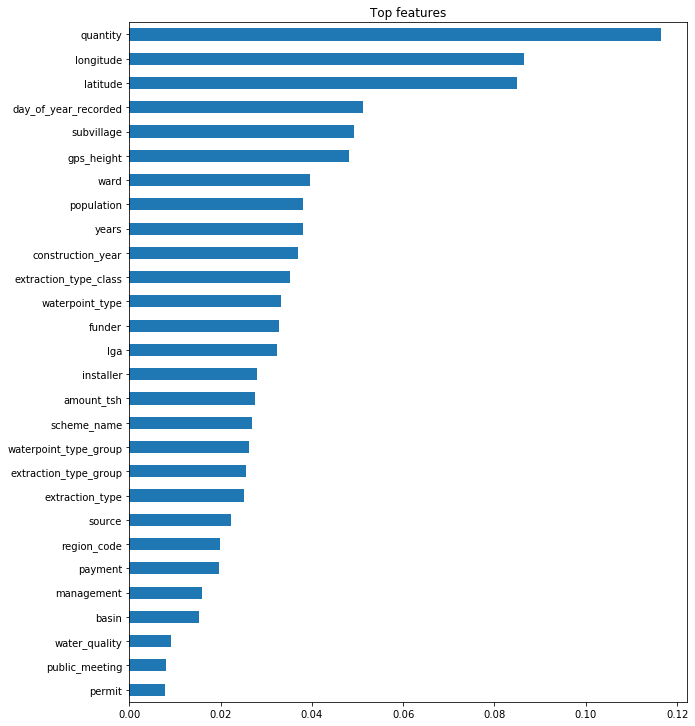

In [20]:
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)
n = 50
plt.figure(figsize=(10,n/4))
plt.title(f'Top features')
importances.sort_values()[-n:].plot.barh();

In [21]:
y_pred = pipeline.predict(X_test)
y_pred.shape

(14358,)

In [22]:

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('willsn_submission.csv', index=False)


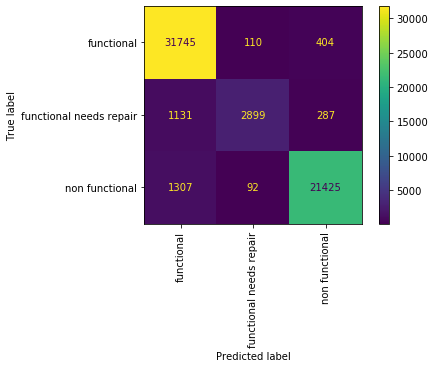

In [29]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline, X_train, y_train, values_format='.0f', xticks_rotation='vertical');
###Just using X_train and y_train instead of _val because I have cross validation set up.